# Read TRADES grid_to_ttv simulation and plot

In [25]:
%matplotlib inline
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import os
import sys
import h5py
import scipy.odr as sciodr

Import custom module within TRADES/pytrades/cheops folder

In [26]:
module_path=os.path.abspath('/data2/borsato/TRADESsimulations/local_trades/trades-run-01/pytrades/cheops')
sys.path.append(module_path)
import trades_grid_to_ttv_level as g2ttv
gls_path=os.path.abspath('/home/borsato/src/GLS/pyGLS')
sys.path.append(gls_path)
import gls

Specify all the needed input folder/file/info:

In [27]:
w8g_folder = os.path.abspath('/data2/borsato/TRADESsimulations/wasp-8/GRID/')
# sim_folder = os.path.join(w8g_folder, '2018-03-12_w8_outer_test/2018-03-12_test/')
sim_folder = os.path.join(w8g_folder, '2017-05-24_w8_outer_grid_Plt40d_001/2017-05-24_grid2ttv_001/')
out_folder = os.path.join(sim_folder, 'plots')
if(not os.path.isdir(out_folder)):
    os.makedirs(out_folder)
hdf5_name = os.path.join(sim_folder, 'rms_analysis_summary.hdf5')
oc_max = 15./1440.
K_rv = 5.
P_tra = 8.158715

Run the function that will create plots in the `out_folder`

In [28]:
reload(g2ttv)
plotit = g2ttv.read_and_plot_p_vs_m_vs_chi2r
plt_fmean, plt_fmed = plotit(out_folder, hdf5_name, rms_oc_max=oc_max, K_rv=K_rv, P_tra=P_tra)

 - Read hdf5 file ...  done
 - Create mass, period grid vs chi2r/rmsOC/rmsRV ... done
 - plot mean MC ...
 Plot n. 0: 
 | mesh/contourf done
 | mesh/contour rms done
 | RV min = 0.368955 m/s max = 15.642585 m/s
 | mesh/contourf rv done
 Plot n. 1: 
 | mesh/contourf done
 | mesh/contour rms done
 | RV min = 0.368955 m/s max = 15.642585 m/s
 | mesh/contourf rv done
 Plot n. 2: 
 | mesh/contourf done
 | mesh/contour rms done
 | RV min = 0.368955 m/s max = 15.642585 m/s
 | mesh/contourf rv done
 Plot n. 3: 
 | mesh/contourf done
 | mesh/contour rms done
 | RV min = 0.368955 m/s max = 15.642585 m/s
 | mesh/contourf rv done
 Plot n. 4: 
 | mesh/contourf done
 | mesh/contour rms done
 | RV min = 0.368955 m/s max = 15.642585 m/s
 | mesh/contourf rv done
 Plot n. 5: 
 | mesh/contourf done
 | mesh/contour rms done
 | RV min = 0.368955 m/s max = 15.642585 m/s
 | mesh/contourf rv done
/data2/borsato/TRADESsimulations/wasp-8/GRID/2017-05-24_w8_outer_grid_Plt40d_001/2017-05-24_grid2ttv_001/plots/p_v

In [29]:
class sim_data:
    def __init__(self, g_h5):
        self.sim_id = g_h5.name.split('/')[-1]
        self.id_num = int(self.sim_id.split('sim_')[1])
        self.T0_eT0 = g_h5['T0_eT0'][...]
        self.rms_ttv = g_h5['rms_ttv'][...][0]
        self.perturber_par = g_h5['perturber_par']
        self.Tref = None
        self.eTref = None
        self.Pref = None
        self.ePref = None
        self.epo = None
        self.oc = None
        
        
class grid_data:
    def __init__(self, hdf5_name):
        f_h5 = h5py.File(hdf5_name, 'r')
        self.grid_par = f_h5['grid/perturber_grid'][...] # parameters perturber: M 0, P 2
        self.err_T0_d = f_h5['grid'].attrs['err_T0_day']
        self.ngrid, self.npar = np.shape(self.grid_par)
        try:
            self.attv_g = f_h5['grid/A_TTV'][...] # in min
            self.pttv_g = f_h5['grid/P_TTV'][...] # in days
        except:
            print 'A_TTV or P_TTV not in the hdf5 file...setting to None'
            self.attv_g = None
            self.pttv_g = None
        
        gh5s = [g for g in f_h5.keys() if 'sim_' in g]
       
        self.sims = [sim_data(f_h5[g]) for g in gh5s]

        f_h5.close()

In [30]:
def lin_func(par, xdata):
    return par[0] + par[1]*xdata
def compute_linephem(TT, eTT, Ptra):
#     TT0 = TT[0]
    TT0 = np.median(TT)
    x = np.rint((TT-TT0)/Ptra).astype(int)
    y = TT
    err_y = eTT
    lin_model = sciodr.Model(lin_func) # Create a Model
    odr_data = sciodr.RealData(x, y, sy=err_y) # Create RealData
    init_par = [TT0, Ptra] # initial parameters
    #Instantiate ODR with your data, model and initial parameter estimate
    odr_mod = sciodr.ODR(odr_data, lin_model, beta0=init_par)
    # RUN IT and store output (scipy version 0.16.0) into an object!
    odr_out = odr_mod.run()
    Tref, Pref = odr_out.beta[0], odr_out.beta[1]
    eTref, ePref = odr_out.sd_beta[0], odr_out.sd_beta[1]
    return x, Tref, eTref, Pref, ePref
    
def compute_ttv(sim, Pref, amp_thr=0.5):
    
    nTT = np.shape(sim.T0_eT0)[0]
    TT0 = sim.T0_eT0[0]
    if(nTT == 2 and TT0 == 0.):
        attv = 0.
        pttv = 0.
    else:
        TT = sim.T0_eT0[:,0]
        eTT = sim.T0_eT0[:,1]
        epo, Tref, eTref, Pref, ePref = compute_linephem(TT, eTT, P_tra)
        TTlin = Tref + Pref * epo
        oc = TT - TTlin
        rmsoc = 0.5*(np.max(oc)-np.min(oc))
        sim.Tref, sim.eTref = Tref, eTref
        sim.Pref, sim.ePref = Pref, ePref
        sim.epo = epo
        sim.oc = oc
        if(rmsoc*1440. < amp_thr):
            attv = rmsoc*1440.
            pttv = -1.
        else:
            ogls = gls.Gls((TT, oc, eTT),
                       Pbeg=3.*Pref, Pend=2.*(TT[-1]-TT[0]),
                       ofac=10, verbose = False
                       )
            attv = ogls.hpstat['amp']*1440.
            pttv = 1./ogls.hpstat['fbest']
            del ogls
    
    return attv, pttv

import gc
def none_ttv_to_values(gall, P_tra):
    
    if(gall.attv_g is None):
        print 'A_TTV is None'
        gall.attv_g = np.zeros((gall.ngrid))
        gall.pttv_g = np.zeros((gall.ngrid))
        print 'computing TTV for sim ... '
        cnt = 0
        for igr in range(0, gall.ngrid):
            cnt = (100.*(igr+1.)/gall.ngrid)
            if(cnt%10. == 0.):
                print '%4.0f%%' %(cnt)
            gall.attv_g[igr], gall.pttv_g[igr] = compute_ttv(gall.sims[igr], P_tra, amp_thr=gall.err_T0_d*2.)
        gc.collect()
        print 'completed'
    return gall

In [31]:
grid_all = grid_data(hdf5_name)

A_TTV or P_TTV not in the hdf5 file...setting to None


In [32]:
print 'ngrid: ',grid_all.ngrid
print 'nsims:', len(grid_all.sims)
print 'grid_par type:', type(grid_all.grid_par)
print 'grid_par shape:', np.shape(grid_all.grid_par)

ngrid:  19200
nsims: 19200
grid_par type: <type 'numpy.ndarray'>
grid_par shape: (19200, 10)


In [33]:
# import copy
# gall = copy.deepcopy(grid_all)
gall = grid_all
gall = none_ttv_to_values(gall, P_tra)

A_TTV is None
computing TTV for sim ... 
No output of frequency error.
Increase frequency range to sample the peak maximum.
No output of frequency error.
Increase frequency range to sample the peak maximum.
No output of frequency error.
Increase frequency range to sample the peak maximum.
No output of frequency error.
Increase frequency range to sample the peak maximum.
No output of frequency error.
Increase frequency range to sample the peak maximum.
No output of frequency error.
Increase frequency range to sample the peak maximum.
No output of frequency error.
Increase frequency range to sample the peak maximum.
No output of frequency error.
Increase frequency range to sample the peak maximum.
No output of frequency error.
Increase frequency range to sample the peak maximum.
No output of frequency error.
Increase frequency range to sample the peak maximum.
No output of frequency error.
Increase frequency range to sample the peak maximum.
No output of frequency error.
Increase frequen

In [34]:
def get_ttv_info(grid_all, min_attv=None, max_attv=5.):

    mper = grid_all.grid_par[:,0]
    pper = grid_all.grid_par[:,2]
    attv_g = grid_all.attv_g
    pttv_g = grid_all.pttv_g
    
    if(min_attv is None):
        min_asel = grid_all.err_T0_d*1440. * 3.
    else:
        min_asel = min_attv
    sel_attv = np.logical_and(attv_g >= min_asel, attv_g <= max_attv)
    attv_sel = attv_g[sel_attv]
    pttv_sel = pttv_g[sel_attv]
    
    min_p_idx = np.argmin(pttv_sel)
    max_p_idx = np.argmax(pttv_sel)
    
    print 'MINIMUM P_TTV = %.6f d with A_TTV = %.6f min' %(pttv_sel[min_p_idx], attv_sel[min_p_idx])
    print 'MAXIMUM P_TTV = %.6f d with A_TTV = %.6f min' %(pttv_sel[max_p_idx], attv_sel[max_p_idx])
    
    msel = mper[sel_attv]
    psel = pper[sel_attv]
    

    return sel_attv

In [35]:
sel_attv = get_ttv_info(gall, min_attv=0.5)

MINIMUM P_TTV = 34.215436 d with A_TTV = 0.520715 min
MAXIMUM P_TTV = 2545.650934 d with A_TTV = 1.988356 min


In [36]:
def plot_sel_par(attv_g, pttv_g, pper, mper, sel_attv, P_tra):
    
    attv_sel = attv_g[sel_attv]
    pttv_sel = pttv_g[sel_attv]
    psel = pper[sel_attv]
    msel = mper[sel_attv]
    
    fig_a = plt.figure(figsize=(14,8))
    plt.title('$P_\\textrm{tra} = %.6f\, \\textrm{days} - A_\\textrm{TTV}$ (min)' %(P_tra), fontsize=12)
    plt.scatter(psel/P_tra, msel, s=100, c=attv_sel,
                cmap=mpl.cm.viridis,
                alpha=0.3
               )
    plt.xlabel('$P_\\textrm{per}/P_\\textrm{tra}$', fontsize=12)
    plt.ylabel('$M_\\textrm{per}\, (M_\oplus)$', fontsize=12)
    plt.colorbar(label='$A_\\textrm{TTV}\, $(min)')
    
    fig_b = plt.figure(figsize=(14,8))
    plt.title('$P_\\textrm{tra} = %.6f\, \\textrm{days} - P_\\textrm{TTV}$ (days)' %(P_tra), fontsize=12)
    plt.scatter(psel/P_tra, msel, s=100, c=pttv_sel,
                cmap=mpl.cm.viridis,
                alpha=0.3
               )
    plt.xlabel('$P_\\textrm{per}/P_\\textrm{tra}$', fontsize=12)
    plt.ylabel('$M_\\textrm{per}\, (M_\oplus)$', fontsize=12)
    plt.colorbar(label='$P_\\textrm{TTV}\, $(days)')
       
    return

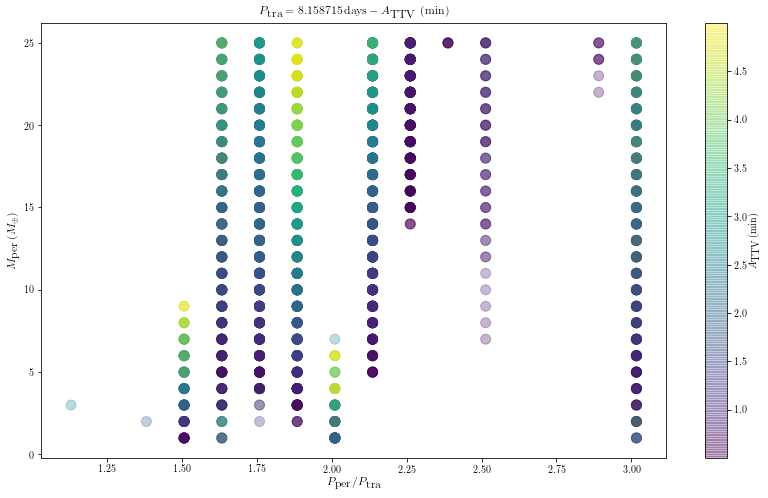

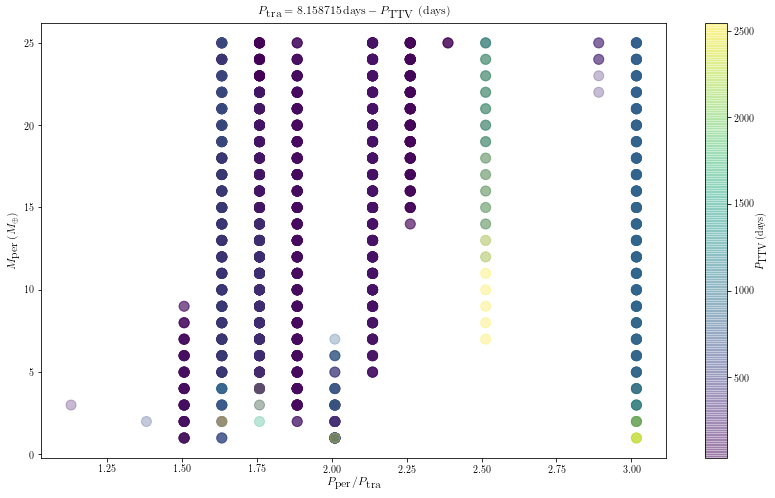

In [37]:
plot_sel_par(gall.attv_g, gall.pttv_g, gall.grid_par[:,2], gall.grid_par[:,0], sel_attv, P_tra)

In [45]:
def plot_oc(gall, Tscale=0.):
    nsims = len(gall.sims)
    
    fig = plt.figure(figsize=(14,8))
    xlabel = 'BJD$_\\textrm{TDB}$ (days)'
    if(Tscale != 0.):
        xlabel = '%s - %.5f' %(xlabel, Tscale)
    plt.xlabel(xlabel, fontsize=13)
    plt.ylabel('O-C (min)', fontsize=13)
    
    cvir = mpl.cm.get_cmap('viridis')
    
    for sim in gall.sims:
        csim = np.float64(sim.id_num)/nsims
        if(len(np.shape(sim.T0_eT0)) > 1 or gall.pttv_g[sim.id_num-1] > 0.):
            TT = sim.T0_eT0[:,0] - Tscale
            eTTm = sim.T0_eT0[:,1]*1440.
            ocm = sim.oc * 1440.
            plt.errorbar(TT, ocm, yerr=eTTm,
                         marker='o', ms=2, ls='',
                         color=cvir(csim),
                         ecolor='lightgrey', capsize=0.,
                         alpha=0.1
                        )    

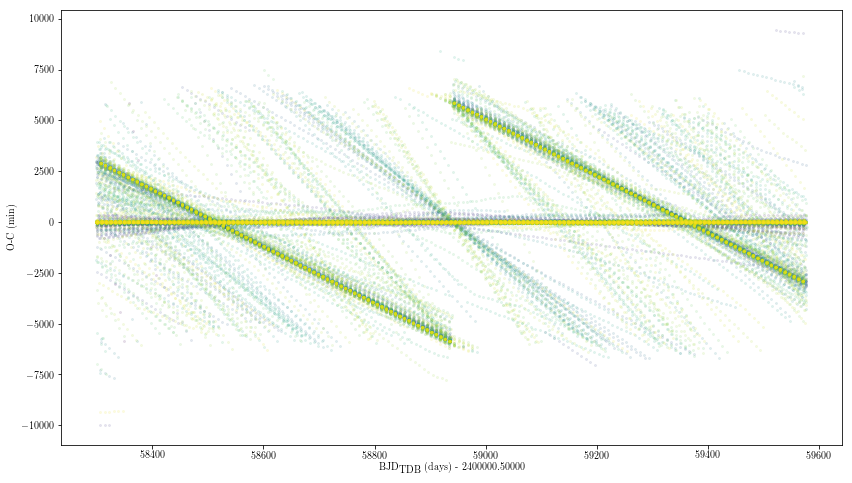

In [46]:
plot_oc(gall, Tscale=2400000.5)